In [11]:
image_filepath = "bunny_img.png"
sketch_contour_filepath = "sketch_contours.png"

In [3]:
pip install gradio==4.7.1


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
#Get the sketch contours from the bunny image, source: https://huggingface.co/spaces/hossay/image-to-sketch (using the provided API)
#Takes about 30 seconds
#Contours are saved in the sketch_contour_filepath specified in the cell above
#Previously used: https://huggingface.co/spaces/awacke1/Image-to-Line-Drawings, but contours were too complex to work with, even after simplification
#Also played around with OpenCV countours/Canny edge detection, but they weren't detailed enough and didn't capture the surface as well (more details in Notebook #1)
#Previous work on suggestive contours: https://gfx.cs.princeton.edu/proj/sugcon/
import os
import requests
from PIL import Image
import gradio as gr
import gradio.utils as gr_utils
from gradio_client import utils as client_utils

# To convert your image file into the base64 format required by the API
img_base64 = client_utils.encode_url_or_file_to_base64(image_filepath)

# To convert the base64 image returned by the API to an image tmp file object

response = requests.post("https://hossay-image-to-sketch.hf.space/run/predict", json={
  "data": [img_base64]}).json()


data = response["data"][0]

# Decode base64 to a temporary file
new_img_temp_file = client_utils.decode_base64_to_file(data)
new_img = Image.open(new_img_temp_file)
new_img.save(sketch_contour_filepath)
# # Get the path of the temporary file
# new_img_path = new_img_temp_file.name

# # Define the directory and file paths
# output_directory = os.path.dirname(sketch_contour_filepath)

# # Create the directory if it doesn't exist
# os.makedirs(output_directory, exist_ok=True)

# with open(new_img_path, "rb") as temp_file:
#     with open(sketch_contour_filepath, "wb") as save_file:
#         save_file.write(temp_file.read())

The following cell takes the contours and simplifies them for drawing. The source is this paper: https://dl.acm.org/doi/pdf/10.1145/2897824.2925972, the repo that our code is based off of is here: https://github.com/bobbens/sketch_simplification, specifically the version of this pull request: https://github.com/bobbens/sketch_simplification/pull/12 since the original version contained depricated models and code. This pull request updates the code to use torch version 1.x. Also, the model is downloaded from: https://mega.nz/#F!2lUn1YbY!JhTkB1vdaBMeTCSs37iTVA as described in the pull request.

In [19]:
run simplify.py --img "sketch_contours.png"

In [23]:
#display the sketch contours and the simplified contours side-by-side
from PIL import Image, ImageDraw

# Open the first image
img_path1 = "sketch_contours.png"
img1 = Image.open(img_path1)

# Open the second image
img_path2 = "out.png"
img2 = Image.open(img_path2)

# Make images the same size
max_width = max(img1.width, img2.width)
max_height = max(img1.height, img2.height)

img1 = img1.resize((max_width, max_height))
img2 = img2.resize((max_width, max_height))

# Create a new image with both images side by side
new_img = Image.new("RGB", (2 * max_width, max_height))
new_img.paste(img1, (0, 0))
new_img.paste(img2, (max_width, 0))

# Display the new image
new_img.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9651abc2-eeb7-42d8-826f-09f5a16b2834' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

Next, we will vectorize the simplified image in order to be able to follow it for the trajectory
Used: https://github.com/tatarize/potrace to install potrace. - pure python binding for potrace, some code from there as well

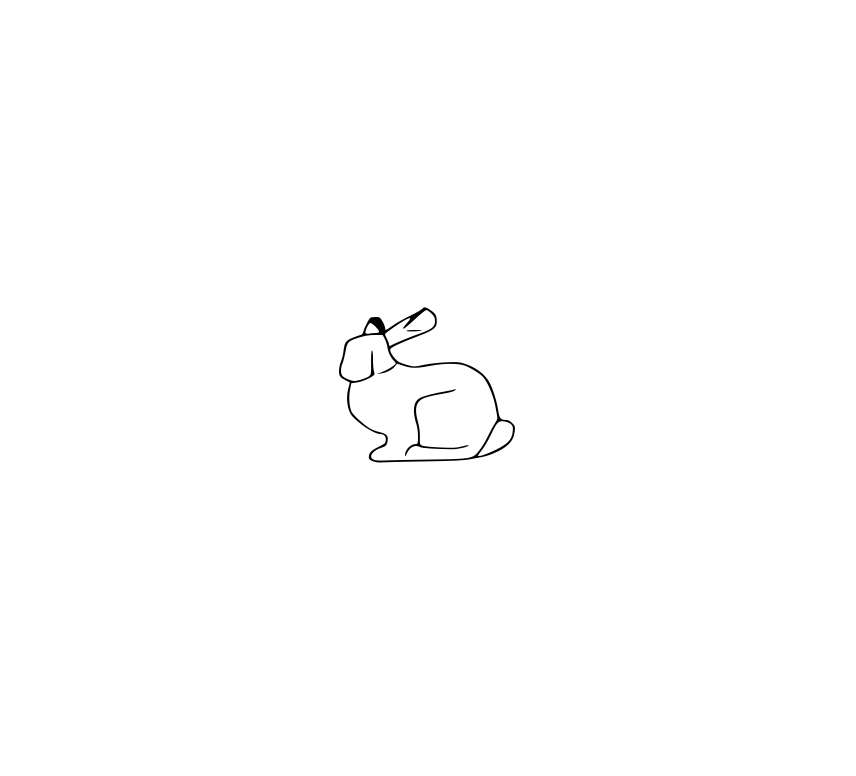

In [61]:
import numpy as np
from matplotlib import pyplot as plt
import potrace
from PIL import Image, ImageOps
from IPython.display import SVG, display

simplified_contours = Image.open("out.png")

geryscale_contours = ImageOps.grayscale(simplified_contours)

pixels = np.array(geryscale_contours)

# Create a bitmap from the array
bmp = potrace.Bitmap(pixels)

# Trace the bitmap to a path
path = bmp.trace()

with open("out.svg", "w") as fp:
        fp.write(
            f'''<svg version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="{simplified_contours.width}" height="{simplified_contours.height}" viewBox="0 0 {simplified_contours.width} {simplified_contours.height}">''')
        parts = []
        for curve in path:
            fs = curve.start_point
            parts.append(f"M{fs.x},{fs.y}")
            for segment in curve.segments:
                if segment.is_corner:
                    parts.append(f"L{segment.c.x},{segment.c.y}L{segment.end_point.x},{segment.end_point.y}")
                else:
                    parts.append(f"C{segment.c1.x},{segment.c1.y} {segment.c2.x},{segment.c2.y} {segment.end_point.x},{segment.end_point.y}")
            parts.append("z")
        fp.write(f'<path stroke="none" fill="black" fill-rule="evenodd" d="{"".join(parts)}"/>')
        fp.write("</svg>")

with open("out.svg", "r") as svg_file:
    svg_content = svg_file.read()
    display(SVG(svg_content))

Hello World
